In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import utils as utils


In [10]:
df_vehicles = pd.read_csv('./data/vehicles.csv')


In [11]:
df_vehicles.shape


(426880, 26)

## Basic cleaning

In [12]:
def basic_clean(df):
    useless_columns = ['id', 'url', 'region_url', 'image_url', 'posting_date', 'VIN', 'county', 'size']
    cleaned_df = df.drop(columns=useless_columns)

    # remove na, or we can impute year based on model, manufactures
    cleaned_df = cleaned_df.dropna(subset=['year'])

    # drop 'description', or we can use NLP technique to extract useful feature
    cleaned_df = cleaned_df.drop(columns=['description'])

    print('remaining columns: \n', df.columns[~df.columns.isin(useless_columns + ['description'])].values)

    cleaned_df = cleaned_df[ cleaned_df['price'] > 0 ]

    return cleaned_df


In [13]:
df = basic_clean(df_vehicles)

df.shape


remaining columns: 
 ['region' 'price' 'year' 'manufacturer' 'model' 'condition' 'cylinders'
 'fuel' 'odometer' 'title_status' 'transmission' 'drive' 'type'
 'paint_color' 'state' 'lat' 'long']


(392812, 17)

## region

In [14]:
utils.missing_table(df[['region']])


No missing values!


## state

In [15]:
utils.missing_table(df[['state']])


No missing values!


In [16]:
df['state'].unique(), len(df['state'].unique())

(array(['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
        'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
        'mi', 'mn', 'ms', 'mo', 'mt', 'nc', 'ne', 'nv', 'nj', 'nm', 'ny',
        'nh', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
        'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'], dtype=object),
 51)

50 states in US plus the Federal district (DC)


## lat

In [17]:
utils.missing_table(df[['lat']])


,counts,percent
lat,3427,1.0


<AxesSubplot:>

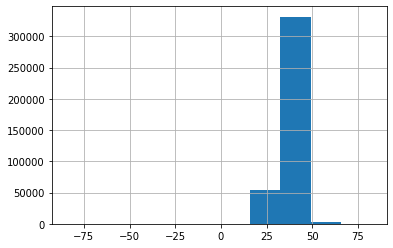

In [18]:
df['lat'].hist()


<AxesSubplot:xlabel='lat'>

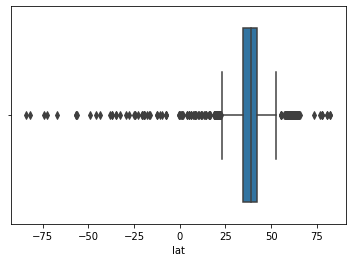

In [19]:
sns.boxplot(data=df, x='lat')


## long

In [20]:
utils.missing_table(df[['long']])


,counts,percent
long,3427,1.0


<AxesSubplot:>

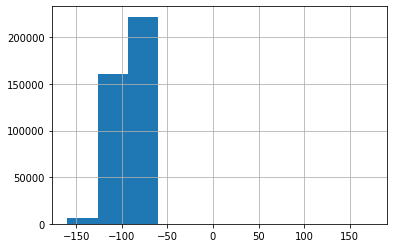

In [21]:
df['long'].hist()


<AxesSubplot:xlabel='long'>

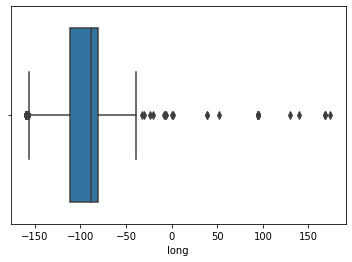

In [22]:
sns.boxplot(data=df, x='long')


**Comments**

- region, state, lat, long are redudant factors

- lthe value of lat and long are the location of US, but there are missing values
 - people don't exactly know what they are
 - mobile GPS may be not open
 
- instead, people are more familiar with region and state

- use 'state' as a location feature, (region is a more smaller area, now we don't consider this)

maybe we could build models for each state?


## manufacturer

In [23]:
df['manufacturer'].unique(), len(df['manufacturer'].unique())


(array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
        'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
        'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
        'subaru', nan, 'acura', 'hyundai', 'mercedes-benz', 'bmw',
        'mitsubishi', 'volkswagen', 'porsche', 'kia', 'rover', 'ferrari',
        'mini', 'pontiac', 'fiat', 'tesla', 'saturn', 'mercury',
        'harley-davidson', 'datsun', 'aston-martin', 'land rover',
        'morgan'], dtype=object),
 43)

In [24]:
country_manufacture_mapping = {
    'USA': [
        'chevrolet', 'jeep', # 1st-class
        'tesla', 'buick', 'ford', 'gmc', 'ram', # 2nd-class
        'lincoln','dodge','chrysler', 'cadillac', 'pontiac', 'mercury', 'saturn', 'harley-davidson'
           ],
    'Japan': [
            'toyota', 
            'acura', 'nissan','infiniti', 'lexus', 
            'honda', 'mitsubishi', 'datsun', 'subaru', 'mazda', 
    ],
    'Germany': [
        'mercedes-benz',
        'bmw', 'audi', 'porsche', 
        'volkswagen' 
    ],
    'UK': [
            'aston-martin', 
            'rover', 'jaguar',  
            'mini','land-rover', 'morgan'
    ],
    'Italy': [
        'ferrari', 
        'alfa-romeo',
        'fiat', 
    ],
    'Korea': ['hyundai', 'kia'],
    'Sweden': ['volvo'],
}

manufacturer
alfa-romeo     29113.680460
ferrari       126008.395062
fiat           12198.562176
Name: price, dtype: float64

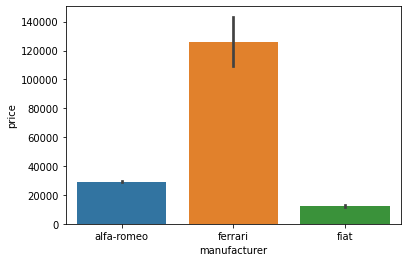

In [25]:
country_group = df[df['manufacturer'].isin(country_manufacture_mapping['Italy'])]

sns.barplot(data=country_group, x='manufacturer', y='price')

country_group.groupby(['manufacturer'])['price'].mean()


**Comments**

Following are manufactures whose prices are significantly higher than other manufacutures 

- USA: 'jeep', 'chevrolet'; 'tesla', 'buick', 'ford', 'gmc', 'ram',

- Japan: toyota; nissan, lexus, infiniti, acurami

- Germany: mercedes-benz; audi, bmw, posche

- UK: aston-martin; jaguar, rover

- Italy: ferrari; alfa-romeo


TODO: prestigae cars are much higher than common cars(Benz is much higher than bmw) when compared in the same country, so we can further indicate the class of the car in the same conuntry based on 'manu_country' .


In [26]:
def clean_manufacture(df):
    for country, manufactures in country_manufacture_mapping.items():
        df.loc[df['manufacturer'].isin(manufactures), 'manu_country'] = country

    df.loc[df['manufacturer'].isna(), 'manu_country'] = 'missing'

    return df


## model

In [27]:
df['model'].unique()[:5], len(df['model'].unique())


(array(['sierra 1500 crew cab slt', 'silverado 1500',
        'silverado 1500 crew', 'tundra double cab sr', 'f-150 xlt'],
       dtype=object),
 28101)

**Comments**

- first try: drop 'model'


## condition


NA           150216
good         119155
excellent     94925
like new      20060
fair           6729
new            1132
salvage         595
Name: condition, dtype: int64


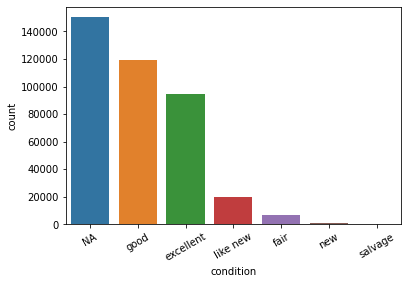

In [28]:
utils.plot_counts_na(df, 'condition')


<AxesSubplot:xlabel='condition', ylabel='price'>

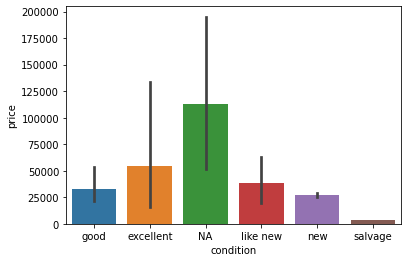

In [29]:
sns.barplot(data=df[
 ~df['condition'].isin(['fair'])
], x='condition', y='price')



<AxesSubplot:xlabel='condition', ylabel='odometer'>

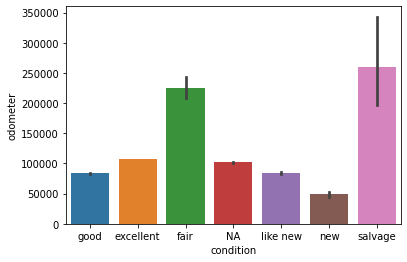

In [30]:
sns.barplot(data=df, x='condition', y='odometer')


**Comments**

- most cars are in good or excellent conditions

- Cars with higher odometer are in poor condition(fair, salvage)

- Cars in poor condition are worthless.

- People prefer cars in fair condition maybe because these cars have a relative higher odometers --- cars are used more often than that in good or new contions.

- Cars with missing condtions have similar ododemter compared to cars in excellent or new conditions, but the prices are much larger than them(TODO: Why? Some other factors may affect their prices)



In [31]:
def clean_condition(df):
    poor_condition = [ 'salvage' ]
    fair_condition = [ 'fair' ]
    good_condition = [ 'good', 'excellent', 'like new', 'new']
    
    df.loc[df['condition'].isin(poor_condition), 'condition_odometer'] = 'poor'
    df.loc[df['condition'].isin(fair_condition), 'condition_odometer'] = 'fair'
    df.loc[df['condition'].isin(good_condition), 'condition_odometer'] = 'good'
    df.loc[df['condition'].isna(), 'condition_odometer'] = 'missing'
    return df


## cylinders


NA              160341
6 cylinders      88389
4 cylinders      72657
8 cylinders      66480
5 cylinders       1670
10 cylinders      1382
other             1083
3 cylinders        606
12 cylinders       204
Name: cylinders, dtype: int64


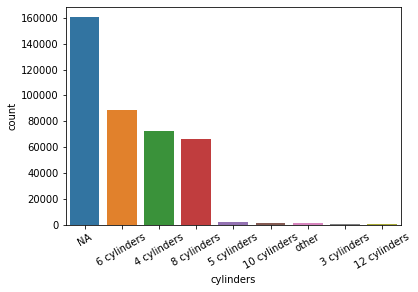

In [32]:
utils.plot_counts_na(df, 'cylinders')


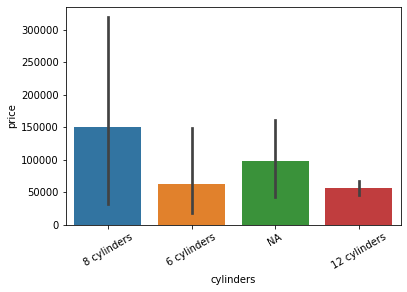

In [33]:

sns.barplot(
        data=df[
            df['cylinders'].isin([
                '8 cylinders', 
                '6 cylinders','12 cylinders', 
                'NA'
            ])
       ],
        x='cylinders', y='price'
)
plt.xticks(rotation=30)
plt.show()


**Comments**

- prices vary significantly in different cylinders

- 8 cylinders has the highest average prices followed by missing cylinders

- 6 and 12 have the same average prices

- 4, 5, 3, 10, other are similar


Maybe we can dig deeper what featuures are related to cylinders



In [34]:
def clean_cylinders(df):
    # each type will be enconded individually
    df.loc[df['cylinders'].isna(), 'cylinders'] = 'missing' # distinguish missing with the existed 'other'
    return df


## fuel

gas         329670
other        28114
diesel       26189
hybrid        4881
NA            2335
electric      1623
Name: fuel, dtype: int64


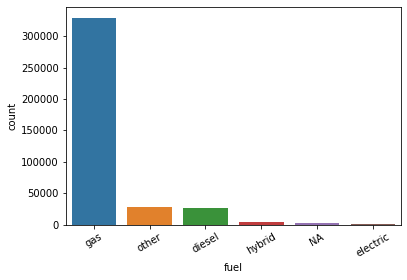

In [35]:
utils.plot_counts_na(df, 'fuel')


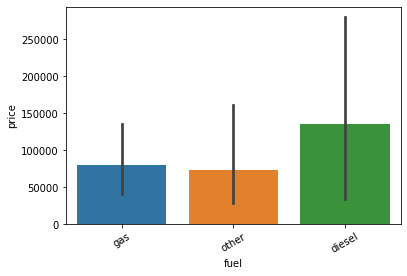

In [36]:

sns.barplot(
        data=df[
            df['fuel'].isin(['gas', 'other', 'diesel'])
        ],
        x='fuel', y='price'
)
plt.xticks(rotation=30)
plt.show()


**comments**

- diesel are expensive

- gas and other are similar

- electric could be individual type

- hybrid and NA are similar



In [37]:
def clean_fule():
    # ['diesel'] => 1st
    # ['gas', 'other'] => common
    # ['electric',]
    # [ 'hybrid', 'NA' ]
    
    df.loc[df['fuel'].isin([ 'diesel' ]), 'fuel_group'] = 'diesel'
    df.loc[df['fuel'].isin(['gas', 'other' ]), 'fuel_group'] = 'gas'
    df.loc[df['fuel'].isin(['electric' ]), 'fuel_group'] = 'electric'

    df.loc[df['fuel'].isin(['hybrid' ]), 'fuel_group'] = 'hybrid'
    df.loc[df['fuel'].isna(), 'fuel_group'] = 'hybrid'
    
    return df
    

## title_status

clean         372108
NA              7430
rebuilt         7030
salvage         3837
lien            1421
missing          797
parts only       189
Name: title_status, dtype: int64


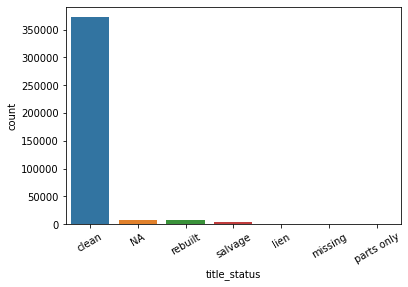

In [38]:
utils.plot_counts_na(df, 'title_status')


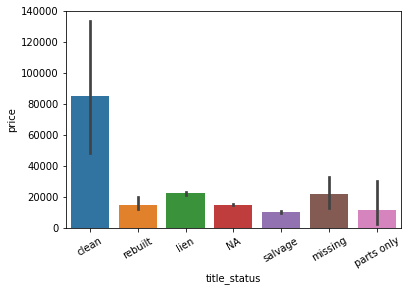

In [39]:

sns.barplot(
        data=df,
        x='title_status', y='price'
)
plt.xticks(rotation=30)
plt.show()


**comments**

- most cars were reported in a clean status

- cars in clean status have the highest average prices

- cars in salvage status have the lowest average prices



In [40]:
def clean_title_status(df):
    df.loc[~df['title_status'].isin([ 'clean' ]), 'tt_status_group'] = 'normal'
    df.loc[df['title_status'].isin([ 'clean' ]), 'tt_status_group'] = 'clean'
    return df


## paint_color

NA        117011
white      72506
black      58310
silver     39941
blue       29397
red        28732
grey       22689
green       7077
custom      6412
brown       6175
yellow      2033
orange      1852
purple       677
Name: paint_color, dtype: int64


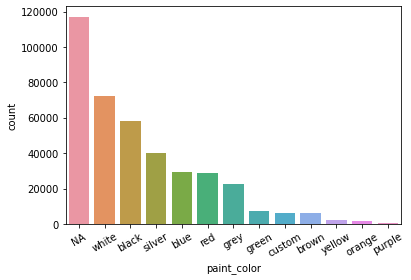

In [41]:
utils.plot_counts_na(df, 'paint_color')


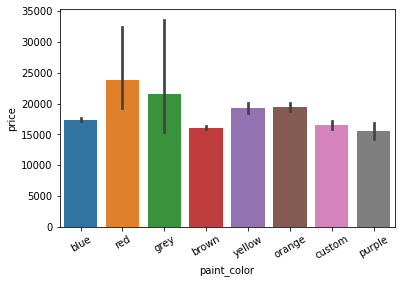

In [42]:

sns.barplot(
        data=df[
            ~df['paint_color'].isin(['green', 'silver', 'NA', 'white', 'black'])
        ],
        x='paint_color', y='price'
)
plt.xticks(rotation=30)
plt.show()


In [43]:
def clean_paint_color(df):
    # ['white', 'black', 'silver', na] => popular
    df.loc[df['paint_color'].isin(['white', 'black', 'silver' ]), 'paint_color_group'] = 'popular'
    df.loc[df['paint_color'].isna(), 'paint_color_group'] = 'popular'

    df.loc[df['paint_color'].isin([
        'blue', 'red', 'grey',
        'green', 'custom', 'brown', 
        'yellow', 'orange', 'purple',
    ]), 'paint_color_group'] = 'common'    
    
    return df


**Comments**

- green cars has the highest cars(but we barely see green cars, maybe because of its speical color or bespoke style. TODO: )


- silver, white and black cars have much higher prices than cars in other colors; they are also the popular colors


- Generally, color is not a decisive factor to buy a car.


So, maybe we could group 'silver, white, black, and NA' as a group, the remaining forms another group



## transmission

automatic    305744
other         61472
manual        23835
NA             1761
Name: transmission, dtype: int64


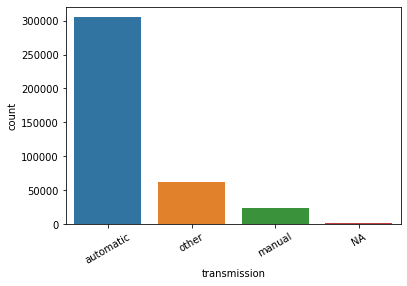

In [44]:
utils.plot_counts_na(df, 'transmission')


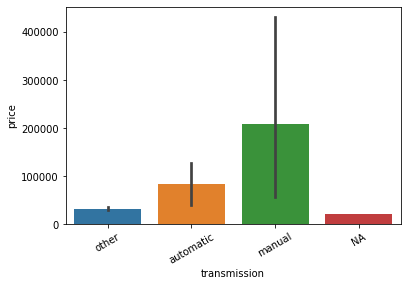

In [45]:

sns.barplot(
        data=df,
        x='transmission', y='price'
)
plt.xticks(rotation=30)
plt.show()


**Comments**
- the average price of cars with missing transmission is similar to 'other'



In [46]:
def clean_transmission(df):
    # impute missing values with 'other' since the average price is similar to 'other'
    df.loc[df['transmission'].isna(), 'transmission'] = 'other'
    return df


## drive

4wd    120292
NA     119972
fwd     97301
rwd     55247
Name: drive, dtype: int64


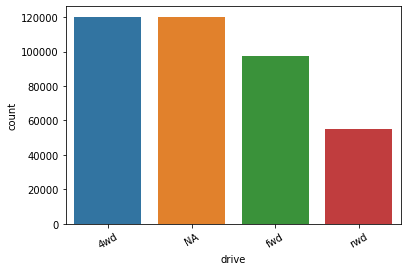

In [47]:
utils.plot_counts_na(df, 'drive')


In [48]:
def clean_drive(df):
    # impute missing values with 'missing'
    df.loc[df['drive'].isna(), 'drive'] = 'missing'
    return df


## type

NA             85758
sedan          80128
SUV            70303
pickup         40997
truck          30634
other          19873
coupe          18191
hatchback      15907
wagon          10064
van             7883
convertible     7430
mini-van        4552
offroad          593
bus              499
Name: type, dtype: int64


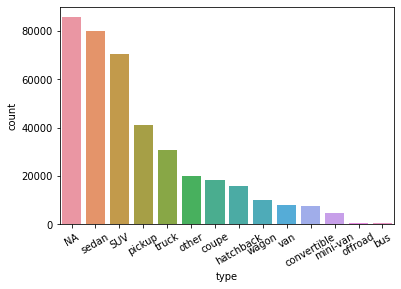

In [49]:
utils.plot_counts_na(df, 'type')


In [50]:
def clean_drive(df):
    # impute missing values with 'missing'
    df.loc[df['type'].isna(), 'type'] = 'missing'
    return df


## year

In [51]:
df_vehicles[['year']].describe()


,year
count,425675.000000
mean,2011.235191
std,9.452120
min,1900.000000
25%,2008.000000
50%,2013.000000
75%,2017.000000
max,2022.000000


In [53]:
utils.missing_table(df_vehicles[['year']])


,counts,percent
year,1205,0.0


In [54]:
df_vehicles['model_s'] = df_vehicles['model'].fillna('Missing')

dc = df_vehicles.groupby(['model_s'])['year'].apply(lambda x: x.fillna(x.mean()))


In [55]:
len(dc), len(df_vehicles), np.sum([pd.isna(dc)])



(426880, 426880, 932)

## odometer

In [57]:
df_vehicles[['odometer']].describe()


,odometer
count,4.224800e+05
mean,9.804333e+04
std,2.138815e+05
min,0.000000e+00
25%,3.770400e+04
50%,8.554800e+04
75%,1.335425e+05
max,1.000000e+07


In [58]:
utils.missing_table(df[['odometer']])


,counts,percent
odometer,2227,1.0


In [59]:
df_vehicles["log_odometer"] = df_vehicles["odometer"].map(lambda i: np.log(i) if i > 0 else 0) 

print(df_vehicles['odometer'].skew())
print(df_vehicles['log_odometer'].skew())


38.04001486053626
-3.767470469969859


<AxesSubplot:>

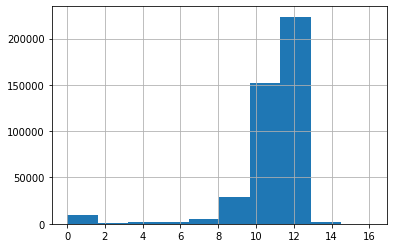

In [60]:
df_vehicles["log_odometer"].hist()


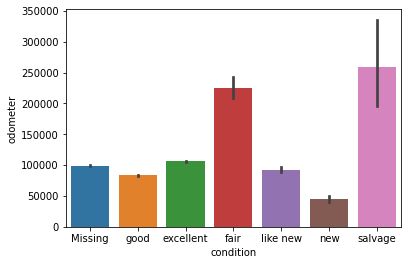

In [61]:
df_vehicles['condition'] = df_vehicles['condition'].fillna('Missing')

sns.barplot(data=df_vehicles, x='condition', y='odometer')

dcd = df_vehicles.groupby(['condition'])['odometer'].apply(lambda x: x.fillna(x.mean()))


In [62]:
len(dcd), len(df_vehicles), np.sum([pd.isna(dcd)])


(426880, 426880, 0)

## price


In [63]:
df_vehicles[['price']].describe()


,price
count,4.268800e+05
mean,7.519903e+04
std,1.218228e+07
min,0.000000e+00
25%,5.900000e+03
50%,1.395000e+04
75%,2.648575e+04
max,3.736929e+09


In [64]:
utils.missing_table(df[['price']])


No missing values!


In [65]:
def clean_price(df):
    # chop
    _, upper_inner_price, _ = utils.cutIQR(df, 'price', q1=0.25, q2=0.75, r = 1.5)

    df.loc[ df['price'] > upper_inner_price, 'price' ] = upper_inner_price

    return df


In [66]:
df_vehicles["log_price"] = df_vehicles["price"].map(lambda i: np.log(i) if i > 0 else 0) 

print(df_vehicles['price'].skew())
print(df_vehicles['log_price'].skew())


254.40693228580142
-2.4155900282339133


<AxesSubplot:>

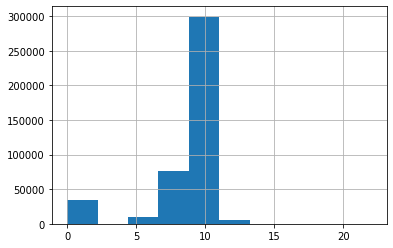

In [67]:
df_vehicles["log_price"].hist()
